In [1]:
import pandas as pd
import numpy as np
from numpy import mean, std, median
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,  train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, recall_score,r2_score, accuracy_score, cohen_kappa_score, classification_report, confusion_matrix, precision_score,f1_score 
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, KFold, StratifiedKFold 
from imblearn.pipeline import Pipeline 
from imblearn.pipeline import make_pipeline as imbpipeline
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
#Random seed used in R was 7
random_seed=7

In [3]:
#read input data
#data=pd.read_csv('GS_majority_vote.csv') #all 986 synsets
data=pd.read_csv('GS_All_Agreed.csv') #839 synsets where all annotators agree

In [4]:
test_data=pd.read_csv('GS_not_agreed_synsets.csv') #synsets where annotators do not agree to test 

In [5]:
d_tools=pd.DataFrame(data.loc[data['domain_x']=='tool'])
d_fruit=pd.DataFrame(data.loc[data['domain_x']=='fruit'])
d_music=pd.DataFrame(data.loc[data['domain_x']=='music'])
d_furn=pd.DataFrame(data.loc[data['domain_x']=='furn'])
d_garm=pd.DataFrame(data.loc[data['domain_x']=='garm'])

In [6]:
len(d_furn)

183

In [7]:
three=data[data['domain_x']!='furn']

In [8]:
fmt=three[three['domain_x']!='garm']

In [9]:
list(data)

['Unnamed: 0',
 'Synsets',
 'domain_x',
 'nrhypos_x',
 'nrdirhypers_x',
 'nrpartrels_x',
 'depthfromtopsynset_x',
 'glosslength_x',
 'minwordlength_x',
 'nroflemmas_x',
 'polyscore_max_x',
 'ngrams_last_mean',
 'nrpartrels_normalised_x',
 'depthfromtopsynset_normalised_x',
 'glosslength_normalised_x',
 'res_ngrams_2008_mean',
 'ngrams_2008_mean_log_y',
 'ngrams_sum08',
 'ngrams_max08',
 'All_CHILDES_mean',
 'All_CHILDES_mean_log',
 'CHILDES_sum',
 'CHILDES_Sum_log',
 'CHILDES_max',
 'CHILDES_max_log',
 'KBNC_mean',
 'KBNC_mean_log',
 'KBNC_Sum',
 'KBNC_Sum_log',
 'KBNC_max',
 'KBNC_max_log',
 'CABNC_mean',
 'CABNC_mean_log',
 'CABNC_sum',
 'CABNC_Sum_log',
 'CABNC_max',
 'CABNC_max_log',
 'BNC_mean',
 'BNC_mean_log',
 'BNC_sum',
 'BNC_Sum_log',
 'BNC_max',
 'BNC_max_log',
 'A1_Label',
 'A2_Label',
 'A3_Label',
 'MV',
 'vote_x',
 'CHILDES_Rel_mean',
 'KBNC_Rel_mean',
 'CABNC_Rel_mean',
 'BNC_Rel_mean',
 'CHILDES_Rel_mean_log',
 'KBNC_Rel_mean_log',
 'CABNC_Rel_mean_log',
 'BNC_Rel_mean_

In [10]:
#set features and target variable
#use best performing features from each corpora 
# 'ngrams_last_mean', 'CHILDES_Sum_Rel','KBNC_Sum','CABNC_per100,000', 'nrdirhypers_x','BNC_sum'
features=[
 'CABNC_per100,000', 
    'nrhypos_x',
    'minwordlength_x',
 'nroflemmas_x',
    'polyscore_max_x',
    'nrpartrels_normalised_x',
    'glosslength_normalised_x',
    'depthfromtopsynset_normalised_x',
    'nrdirhypers_x', 'BNC_sum'
]
target=['vote_x']

In [11]:
#train on 2 domains test on one unseen to see performance across new domains
music=[d_tools, d_fruit] #train on tools and fruit, test on music
fruit=[d_tools, d_music]
tools=[d_fruit, d_music]
m=pd.concat(music)
f=pd.concat(fruit)
t=pd.concat(tools)

In [12]:
#train on 4 domains test on one unseen 
garments=[d_furn, d_fruit, d_music, d_tools] 
furniture=[d_fruit, d_music, d_tools, d_garm]
fru=[d_furn, d_music, d_tools, d_garm]
mus=[d_furn, d_fruit, d_tools, d_garm]
too=[d_furn, d_fruit, d_music, d_garm]
g=pd.concat(garments) #train on furn, fruit, music and tools and test on garments
furn=pd.concat(furniture)
fr=pd.concat(fru)
mu=pd.concat(mus)
to=pd.concat(too)

In [13]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train=np.array(to[features]) #concated df name (g, furn, fr, mu, to) of unseen domain
X_test=np.array(d_tools[features]) #d_domain (d_garm, d_furn, d_fruit..) of unseen domain
y_train=np.array(to[target])
y_test=np.array(d_tools[target])

In [14]:
#run SMOTE algorithm to deal with class imbalances - make basic class same amount as non-basic
sm = SMOTE(random_state=random_seed, k_neighbors=2)
X_train, y_train = sm.fit_resample(X_train, y_train)
print ('Shape of oversampled data: {}'.format(X_train.shape))
print ('Shape of Y: {}'.format(y_train.shape))

Shape of oversampled data: (1112, 10)
Shape of Y: (1112,)


In [15]:
#define model and fit oversampled training sets
rf = RandomForestClassifier(random_state=random_seed, max_features="sqrt", n_estimators=500, oob_score=True, criterion='gini', bootstrap=True).fit(X_train, y_train.ravel())

In [16]:
kappa_scorer=make_scorer(cohen_kappa_score) #to generate kappa scores in CV

In [17]:
#pipeline for CV to first run smote prior to fitting RF in each loop - ensures no data leakage
pipeline=imbpipeline(sm, rf)

In [18]:
#predict test set from training split
y_pred = pipeline.predict(X_test)
cr=(classification_report(y_test,y_pred, output_dict=True))
report=pd.DataFrame(cr).transpose()
report
cr=(classification_report(y_test,y_pred, output_dict=True))
ck=(cohen_kappa_score(y_test, y_pred))
ba=(balanced_accuracy_score(y_test, y_pred))
report=pd.DataFrame(cr).transpose()
report['Cohen Kappa']=ck
report['Balanced Accuracy']=ba

In [19]:
report['Trained on']='fruit, music, furniture and garments'
report['Tested on']='tools'

In [20]:
report

,precision,recall,f1-score,support,Cohen Kappa,Balanced Accuracy,Trained on,Tested on
b,0.869565,0.800000,0.833333,25.00000,0.796714,0.886111,"fruit, music, furniture and garments",tools
nb,0.954545,0.972222,0.963303,108.00000,0.796714,0.886111,"fruit, music, furniture and garments",tools
accuracy,0.939850,0.939850,0.939850,0.93985,0.796714,0.886111,"fruit, music, furniture and garments",tools
macro avg,0.912055,0.886111,0.898318,133.00000,0.796714,0.886111,"fruit, music, furniture and garments",tools
weighted avg,0.938572,0.939850,0.938872,133.00000,0.796714,0.886111,"fruit, music, furniture and garments",tools


Feature: 0, Score: 0.04852
Feature: 1, Score: 0.06821
Feature: 2, Score: 0.08433
Feature: 3, Score: 0.05581
Feature: 4, Score: 0.07016
Feature: 5, Score: 0.13445
Feature: 6, Score: 0.10691
Feature: 7, Score: 0.28460
Feature: 8, Score: 0.00604
Feature: 9, Score: 0.14098


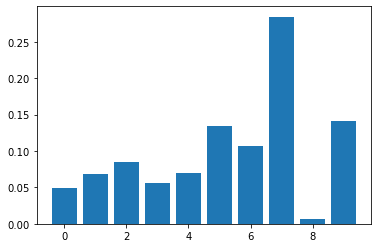

In [21]:
# get feature importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig1=plt.figure()
a=plt.bar([x for x in range(len(importance))], importance)
#plt.savefig('ck/feature_importance_global.png')
plt.show()

In [22]:
imp=[]
for i,v in enumerate(importance):
    imp.append(v)

In [23]:
df4=pd.DataFrame(imp)
df4['Features']=features
df4=df4.rename(columns={0:'Importance'})

In [24]:
df5=df4[['Features', 'Importance']].sort_values('Importance',ascending=False)

In [25]:
df5=df5.rename(columns={'index':'Rank'})

In [26]:
df5

,Features,Importance
7,depthfromtopsynset_normalised_x,0.284601
9,BNC_sum,0.140975
5,nrpartrels_normalised_x,0.134452
6,glosslength_normalised_x,0.106911
2,minwordlength_x,0.084331
4,polyscore_max_x,0.070155
1,nrhypos_x,0.068208
3,nroflemmas_x,0.055806
0,"CABNC_per100,000",0.048521
8,nrdirhypers_x,0.006040


In [27]:
report.to_csv('results/features/unseen/CR_gen_unseen_tools.csv')

In [28]:
df5.to_csv('results/features/unseen/FI_gen_unseen_tools.csv')

In [29]:
#_wNG